# Initial dataset review

## Importing necessary libraries

In [23]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

# downloading package for tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Глебасс\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Unzipping raw dataset

### Setting paths to files

In [24]:
raw_path = '../data/raw/filtered_paranmt.zip' # path to archive
save_path = '../data/interim/preprocessed_ParaNMT-detox.csv' # path for preprocessed archive to save

## Unzipping and reading

In [25]:
# reading raw dataset
initial_df = pd.read_table(raw_path, index_col=0, compression='zip')
initial_df

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
...,...,...,...,...,...,...
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124


## Swapping elements

From showed examples we can see that in the initial dataset there are some values with translation toxicity greater than reference toxicity (e.g. row 0, 1, 2, 3, 4, 577772, 577776). Since our task is detoxifitcation, we need to swap reference and toxicity in these rows. Thus, translation toxicity will be less than reference one

In [26]:
swapped = initial_df['ref_tox'] < initial_df['trn_tox']
cols1 = ['reference', 'ref_tox']
cols2 = ['translation', 'trn_tox']
initial_df.loc[swapped, cols1], initial_df.loc[swapped, cols2] = initial_df.loc[swapped, cols2].values, initial_df.loc[swapped, cols1].values
initial_df

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.785171,0.010309,0.981983,0.014195
1,you're becoming disgusting.,Now you're getting nasty.,0.749687,0.071429,0.999039,0.065473
2,"well, we can spare your life.","Well, we could spare your life, for one.",0.919051,0.268293,0.985068,0.213313
3,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.664333,0.309524,0.994215,0.053362
4,I have orders to kill her.,I've got orders to put her down.,0.726639,0.181818,0.999348,0.009402
...,...,...,...,...,...,...
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...,0.870322,0.030769,0.949143,0.000121
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124


## Dataset preprocessing

Initial dataset is too big. Therefore, I propose to filter it, since it will decrease number of samples and improve data quality. There are 2 values that I want to observe:
* How similar reference and translation are
* How much reference toxicity differs from translation toxicity

### Checking how sparse our data in these 2 metrics

#### Scatter plot

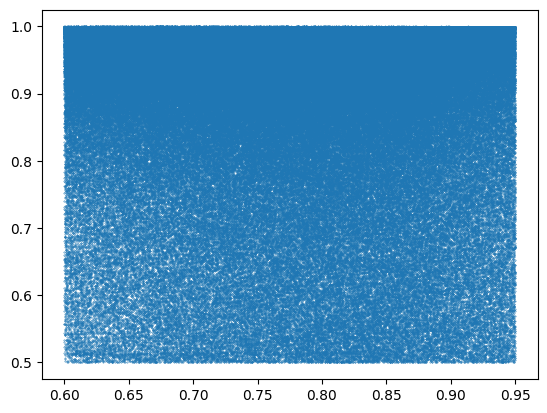

In [27]:
sim = initial_df['similarity'] # similarity column
tox_dif = abs(initial_df['ref_tox'] - initial_df['trn_tox']) # difference column

plt.scatter(sim, tox_dif, s=1/10)
plt.show()

From this plot: there is no interesting points, no outliers that we should check

#### Frequency plots

##### Similarity frequencies

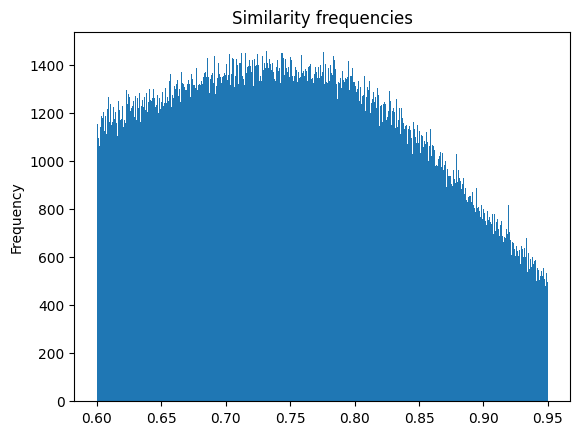

In [28]:
sim.plot.hist(bins=500)
plt.title('Similarity frequencies')
plt.show()

From similarity plot we can see that similarity in data is pretty homogeneous. Therefore, dropping of values less than specific benchmark will not highly affect number of points.

##### Toxicicty difference frequencies

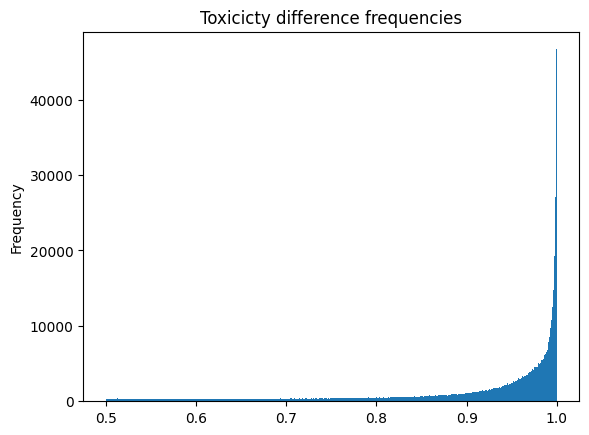

In [29]:
tox_dif.plot.hist(bins=500)
plt.title('Toxicicty difference frequencies')
plt.show()

From toxicicty difference plot we can see that most of the values are near 1.0. Nevertheless, we still can drop values less than specific benchmark, since with increase of the difference number of points  also increases. Thus, we will not drop too many samples.

### Filtering by difference in toxicity between reference and translation

Below we can see examples of data that we will exclude

$\textbf{Toxicity difference benchmark}$ that I will use is $\textbf{0.90}$

In [30]:
tox_dif_benchmark = 0.90 # benchmark for difference in toxicity
distance = tox_dif < tox_dif_benchmark # rows that less than benchmark
filtered_by_distance = initial_df.loc[distance]
filtered_by_distance # data that we will exclude

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
2,"well, we can spare your life.","Well, we could spare your life, for one.",0.919051,0.268293,0.985068,0.213313
7,Maine was very short on black people back then.,there wasn't much black in Maine then.,0.720482,0.187500,0.963680,0.148710
8,"Briggs, what the hell is going on?","Briggs, what the hell's happening?",0.920373,0.000000,0.841071,0.159096
9,"another simply didn't know what to do, so when...","Another one simply had no clue what to do, so ...",0.877540,0.101695,0.930472,0.055371
11,"So now their spirits are cursed, walking back ...","their souls are cursed, they guard the paths, ...",0.755883,0.013245,0.842509,0.143992
...,...,...,...,...,...,...
577766,tell the doctor I'm going to throw the poo.,Tell the doctor I'm dropping a deuce.,0.646018,0.136364,0.874277,0.000456
577767,Who the hell is ringing my bell?,who the hell's ringing?,0.868084,0.272727,0.872644,0.109125
577768,And now nobody wanted to face this madman from...,"now, however, no one wanted to face the madman...",0.799664,0.134328,0.933597,0.042693
577769,Come here and bite me some more.,come here and bite me a little bit.,0.842079,0.083333,0.859086,0.024409


### Filtering by similarity between reference and translation

Below we can see examples of data that we will exclude

$\textbf{Similarity benchmark}$ that I will use is $\textbf{0.70}$

In [31]:
sim_benchmark = 0.70 # benchmark for similarity
similarity = sim < sim_benchmark # rows that less than benchmark
initial_df.loc[similarity] # data that we will exclude

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
3,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.664333,0.309524,0.994215,0.053362
6,"They're all laughing at us, so we'll kick your...",they're laughing at us. We'll show you.,0.618866,0.230769,0.999492,0.000131
13,"Come on, Cal, leave that shit alone.","come on, Cal, put it down.",0.660481,0.270270,0.999637,0.000279
14,he's the tallest son of a bitch.,So he's the Top dog.,0.611092,0.363636,0.999639,0.000920
17,"to quote Jake and Oppenheimer: ""I must die, I ...","To quote Jake Oppenheimer: I, who am about to ...",0.699590,0.178947,0.682655,0.002348
...,...,...,...,...,...,...
577763,"oh, and hell.","Oh, crud.",0.660415,0.285714,0.807995,0.019170
577766,tell the doctor I'm going to throw the poo.,Tell the doctor I'm dropping a deuce.,0.646018,0.136364,0.874277,0.000456
577771,"I thought American men were bad enough, but no...","an American man is worth nothing, but for you,...",0.671444,0.371212,0.999624,0.035941
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049


## Filtered dataset

In [32]:
filtered = initial_df.loc[similarity.apply(lambda x: not x)] # filtering by similarity
filtered = filtered.loc[distance.apply(lambda x: not x)] # filtering by difference in toxicity
filtered

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.785171,0.010309,0.981983,0.014195
1,you're becoming disgusting.,Now you're getting nasty.,0.749687,0.071429,0.999039,0.065473
4,I have orders to kill her.,I've got orders to put her down.,0.726639,0.181818,0.999348,0.009402
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...,0.703185,0.206522,0.950956,0.035846
10,you'd probably want me to buy you some chocola...,I suppose you want me to buy you flowers and c...,0.800661,0.160000,0.980341,0.000078
...,...,...,...,...,...,...
577759,"you're good, just a little immature.","They're okay, just a little immature.",0.841589,0.026316,0.952820,0.042836
577764,"execute him, Chief.","Carry on, Chief.",0.701188,0.150000,0.998043,0.000092
577770,I am so crazy nuts about you guys.,I'm so crazy about you guys.,0.934512,0.171429,0.973442,0.000709
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...,0.870322,0.030769,0.949143,0.000121


### Checking how sparse our filtered data in these 2 metrics

#### Scatter plot

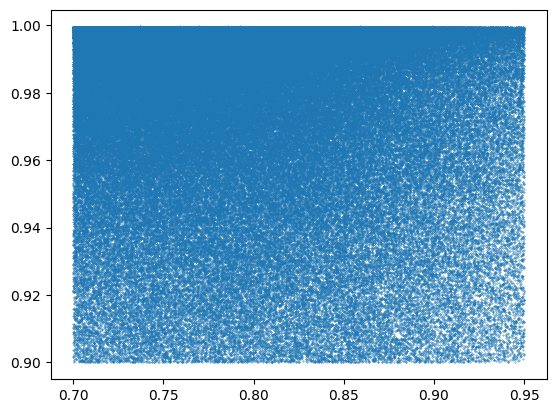

In [33]:
sim = filtered['similarity'] # similarity column
tox_dif = abs(filtered['ref_tox'] - filtered['trn_tox']) # difference column

plt.scatter(sim, tox_dif, s=1/10)
plt.show()

The data became a little sparsier, but still there is no interesting points or outliers.

#### Frequency plots

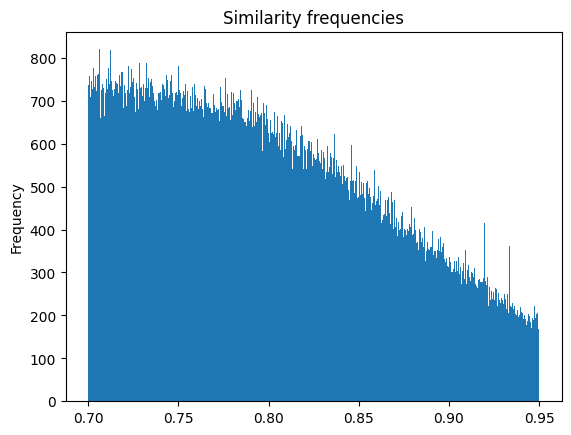

In [34]:
sim.plot.hist(bins=500)
plt.title('Similarity frequencies')
plt.show()

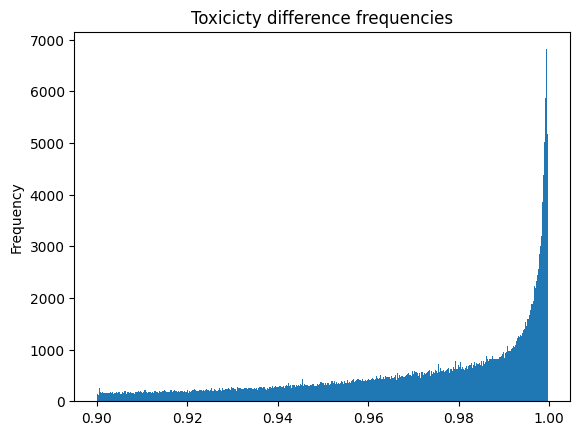

In [35]:
tox_dif.plot.hist(bins=500)
plt.title('Toxicicty difference frequencies')
plt.show()

We can see that frequency plots have hardly changed

## Preparing dataset for training

### Deleting metrics that we will not use

In [36]:
filtered = filtered.drop(['similarity',	'lenght_diff',	'ref_tox',	'trn_tox'], axis=1)
filtered

,reference,translation
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t..."
1,you're becoming disgusting.,Now you're getting nasty.
4,I have orders to kill her.,I've got orders to put her down.
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...
10,you'd probably want me to buy you some chocola...,I suppose you want me to buy you flowers and c...
...,...,...
577759,"you're good, just a little immature.","They're okay, just a little immature."
577764,"execute him, Chief.","Carry on, Chief."
577770,I am so crazy nuts about you guys.,I'm so crazy about you guys.
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...


### Deeper exploration using tokenization

Let's tokenize our samples to get more information about data

In [37]:
def preprocess_text(text: str) -> list[str]: # function for preprocessing dataframe
    text = text.lower()
    return word_tokenize(text, language='english')

In [38]:
tokenized = filtered.copy()
tokenized['reference'] = tokenized['reference'].apply(preprocess_text)
tokenized['translation'] = tokenized['translation'].apply(preprocess_text)
tokenized

,reference,translation
0,"[if, alkar, floods, her, with, her, mental, wa...","[if, alkar, is, flooding, her, with, psychic, ..."
1,"[you, 're, becoming, disgusting, .]","[now, you, 're, getting, nasty, .]"
4,"[i, have, orders, to, kill, her, .]","[i, 've, got, orders, to, put, her, down, .]"
5,"[i, 'm, not, gon, na, have, a, child, ..., ......","[i, 'm, not, going, to, breed, kids, with, a, ..."
10,"[you, 'd, probably, want, me, to, buy, you, so...","[i, suppose, you, want, me, to, buy, you, flow..."
...,...,...
577759,"[you, 're, good, ,, just, a, little, immature, .]","[they, 're, okay, ,, just, a, little, immature..."
577764,"[execute, him, ,, chief, .]","[carry, on, ,, chief, .]"
577770,"[i, am, so, crazy, nuts, about, you, guys, .]","[i, 'm, so, crazy, about, you, guys, .]"
577772,"[you, did, n't, know, that, estelle, stole, yo...","[you, did, n't, know, that, estelle, had, stol..."


### Finding maximal number of tokens in translation and reference

In [39]:
print("Maximal length of translation:", len(max(tokenized['translation'], key=len)))
print("Maximal length of reference:", len(max(tokenized['reference'], key=len)))

Maximal length of translation: 200
Maximal length of reference: 271


### Frequency plot of lengths for reference

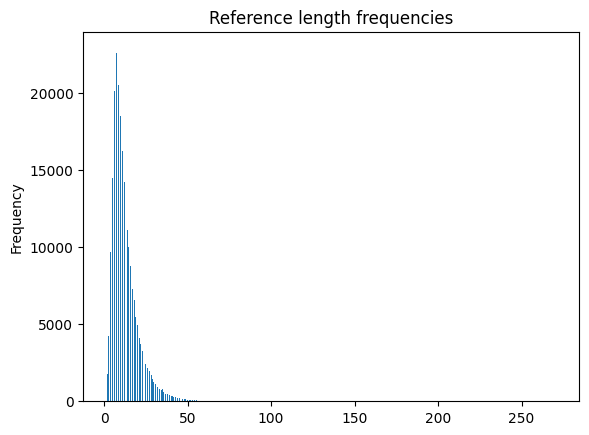

In [40]:
ref_len = tokenized['reference'].apply(lambda x: len(x))
ref_len.plot.hist(bins=500)
plt.title('Reference length frequencies')
plt.show()

### Frequency plot of lengths for translation

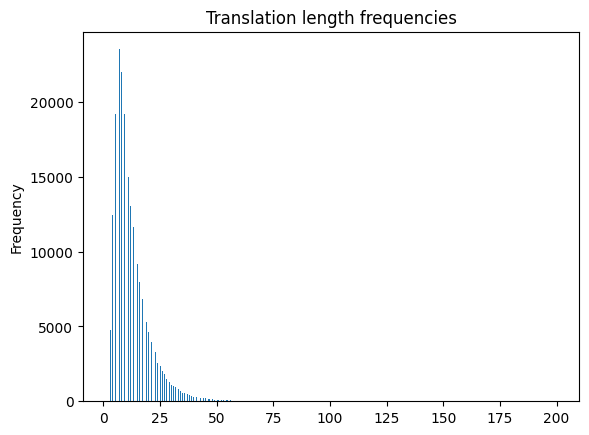

In [41]:
trans_len = tokenized['translation'].apply(lambda x: len(x))
trans_len.plot.hist(bins=500)
plt.title('Translation length frequencies')
plt.show()

Most samples located to the left of 50 for both translation and refernce. Therefore, I decided to $\textbf{drop all samples with length (number of tokens in sentence) greater than 50}$.

### Filtering by length

In [42]:
len_benchmark = 50 # benchmark for length
ref_len_less = ref_len <= len_benchmark # rows with length of reference less than benchmark
trans_len_less = trans_len <= len_benchmark # rows with length of translation less than benchmark

filtered = filtered.loc[ref_len_less] # filtering by reference length
filtered = filtered.loc[trans_len_less] # filtering by tranlsation length
filtered

,reference,translation
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t..."
1,you're becoming disgusting.,Now you're getting nasty.
4,I have orders to kill her.,I've got orders to put her down.
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...
10,you'd probably want me to buy you some chocola...,I suppose you want me to buy you flowers and c...
...,...,...
577759,"you're good, just a little immature.","They're okay, just a little immature."
577764,"execute him, Chief.","Carry on, Chief."
577770,I am so crazy nuts about you guys.,I'm so crazy about you guys.
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...


## Saving preprocessed data

In [43]:
filtered.to_csv(save_path)